In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
from PIL import Image
import imutils

# Cropping and obtaining masks for the threat objects

In [138]:
#copying file names of all threat_images into a list named file_list
file_list = glob.glob('threat_images/*.jpg')

In [139]:
file_list

['threat_images\\t1.jpg',
 'threat_images\\t2.jpg',
 'threat_images\\t3.jpg',
 'threat_images\\t4.jpg',
 'threat_images\\t5.jpg']

In [140]:
threat_area={} # used to store the area of the threat object using the area of it's contour
i=0 #just used to make names for saving images
for file in file_list:  #iterating through each threat image
    i+=1
    img = cv2.imread(file)  #reading the image using cv2 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #converting the image into gray scale
    threshold, binary_inv = cv2.threshold(gray, thresh=245, maxval=255,type=cv2.THRESH_BINARY_INV) #converting image into binary
    contours, hierarchy = cv2.findContours(binary_inv,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE) #finding all contours for the image
    max_box = (0,0,0,0) #to store bounding rectangle for biggest contour as biggest contour will be the threat object
    max_area = 0  # to store area of biggest contour
    
    #to find the contour of the entire threat object 
    for contour in contours: #iterating through every contour obtained
        x,y,w,h = cv2.boundingRect(contour) #getting a bounding rectangle for each contour
        area = w*h #measuring the area of the bounding rectangle
        
        #finding contour with max bounding rectangle area
        if area > max_area: 
            max_box = x,y,w,h
            max_area = area
            
    x,y,w,h = max_box #values of bounding ractangle with max_area
    ROI = img[y:y+h,x:x+w] #cropping out that region of intrest where threat is present from the entire threat image 
    
     #storing these cropped imaged into a new folder cropped_images
    filename = "cropped_threats\\t"+str(i)+"_threat.png"
    threat_area[filename]=max_area
    cv2.imwrite(filename, ROI)

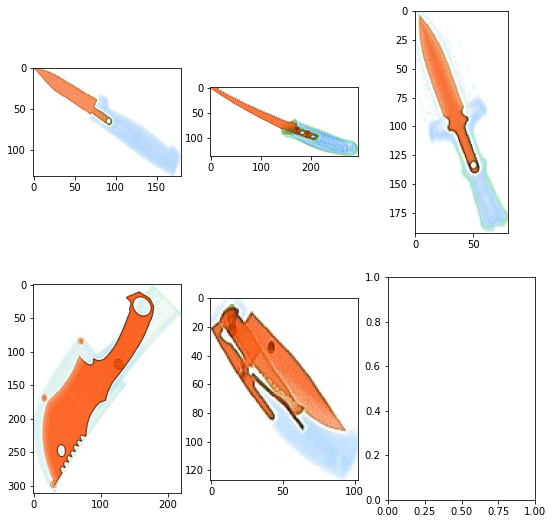

In [141]:
#showing all cropped images
threat_list = glob.glob('cropped_threats\\*_threat.png')
fig, axs = plt.subplots(2, 3,figsize=(9,9))
for i in range(len(threat_list)):
    img = cv2.imread(threat_list[i])
    axs[i%2, i%3].imshow(img)

In [142]:
#making a mask for these cropped images inorder to lay only the threat object and get rid of all surroundings
#initialising a kernel of size 3*3 which will be eventually used for morphological operations
kernel = np.ones((3,3),np.uint8)
#iterating through every cropped threat image
for file in threat_list:
    #reading and converting the image into binary format (inverse binary has been used to make background black)
    img = cv2.imread(file)
    #img = contrast_enhance(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold, binary_inv = cv2.threshold(gray, thresh=245, maxval=255,type=cv2.THRESH_BINARY_INV)
    #using opening operation in order to get rid of surrounding noise (white pixels in black regions)
    binary_inv = cv2.morphologyEx(binary_inv,cv2.MORPH_OPEN, kernel=kernel, iterations=1)
    
    #finding the largest contour for the threat same as done before
    contours, hierarchy = cv2.findContours(binary_inv,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    max_box = (0,0,0,0)
    max_area = 0
    cont_id = -1
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        area = w*h
        if area > max_area:
            max_box = x,y,w,h
            max_area = area
            cont_id = i
    x,y,w,h = max_box
    
    #after  finding the largest contour, iterate through every pixel in that bounding rectangle of that contour and make
    #it as white pixel if it is black. This is needed as we will further use this binary image as mask to crop threat onto bg 
    for i in range(y,y+h+1):
        for j in range(x,x+w+1):
            pos=cv2.pointPolygonTest(contours[cont_id],(i,j),False)
            if(pos==1 and binary_inv[j][i]==0):
                binary_inv[j][i]=255
    
    #storing all masks for each threat with _mask as suffix to its original threat name 
    filename = file[:-4] + "_mask.png"
    cv2.imwrite(filename,binary_inv)

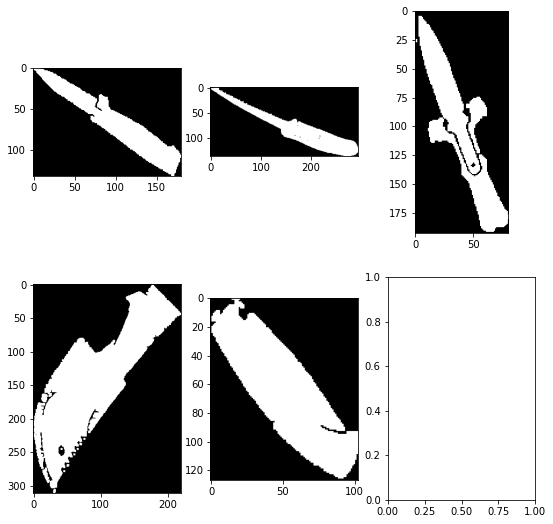

In [143]:
#diisplaying threat's masks
file_list = glob.glob('cropped_threats/*_mask.png')
fig, axs = plt.subplots(2, 3,figsize=(9,9))
for i in range(len(file_list)):
    img = cv2.imread(file_list[i])
    axs[i%2, i%3].imshow(img,'gray')

# BAG boundaries and Blending


In [144]:
#this function is used to paste the translucent threat onto baggage images
def trans_blend(fg_img,bg_img,mask,box=(50,50)):
    bg_img_trans = Image.new("RGBA",bg_img.size,(255, 255, 255, 0))
    bg_img=bg_img.convert("RGBA")
    bg_img_trans.paste(fg_img,box,mask=mask)
    bg1 = Image.blend(bg_img_trans, bg_img,0.35)
    bg2 = Image.blend(bg_img_trans, bg_img,1.0)
    bg=  Image.alpha_composite(bg2,bg1)
    return bg

In [145]:
#storing names of all backgroud_images and threats into lists
file_list = glob.glob('background_images/*.jpg')
threat_list = glob.glob('cropped_threats/*_threat.png')

In [146]:
threat_list

['cropped_threats\\t1_threat.png',
 'cropped_threats\\t2_threat.png',
 'cropped_threats\\t3_threat.png',
 'cropped_threats\\t4_threat.png',
 'cropped_threats\\t5_threat.png']

In [147]:
#this is area of each threat image calculated previously
threat_area

{'cropped_threats\\t1_threat.png': 23760,
 'cropped_threats\\t2_threat.png': 13081,
 'cropped_threats\\t3_threat.png': 15633,
 'cropped_threats\\t4_threat.png': 68420,
 'cropped_threats\\t5_threat.png': 40278}

In [148]:
#here we paste each threat onto each back_ground image and obtain final output
n=0 #used to name output images
for file in file_list: #iterating through every backgronud_image
    #converitng baggage into gray and binary images and finfing contours
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold, binary_inv = cv2.threshold(gray, thresh=252, maxval=255,type=cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(binary_inv,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    #finding the largest contour 
    max_box = (0,0,0,0)
    bag_area = 0
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        #cv2.drawContours(image=img,contours=contours,contourIdx=i, color=(255,0,0), thickness=1)
        area = w*h
        if area > bag_area:
            max_box = x,y,w,h
            bag_area = area
            cont_id=i
    x,y,w,h = max_box
    
    #iterating through each threat 
    for t in threat_list:
        n=n+1
        mask_name= t[:-4]+"_mask.png" #getting mask name for each threat 
        threat=cv2.imread(t)
        mask=cv2.imread(mask_name)
        t_area=threat.shape[0]*threat.shape[1] #calculating area of threat image
        #setting a condinton that arae_of_threat should be less that 1/6th of bag area and scaling down the threat based on those values
        area_of_threat = bag_area/6 
        if threat_area[t] >= area_of_threat:
            scale_factor = (bag_area)/(6*threat_area[t])
        else:
            scale_factor = 0.7
        #reading all baggage, threat and it's respective mask using pillow 
        bg_img = Image.open(file)
        fg_img = Image.open(t)
        mask= Image.open(mask_name) 
        #scaling down threat and rotating it by 45 degrees
        width1, height1 = fg_img.size
        width2, height2 = mask.size
        fg_img = fg_img.resize((round(scale_factor*width1),round(scale_factor*height1)))
        mask = mask.resize((round(scale_factor*width2),round(scale_factor*height2)))
        fg_img = fg_img.rotate(45,fillcolor='white', expand=True)
        mask = mask.rotate(45,fillcolor='black', expand=True)
        #again measuring the size of threat as above transformations will lead to change in image size
        width1, height1 = fg_img.size
        width2, height2 = mask.size
        #blending the baggage  and threat images and saving the output to final_output folder
        p = trans_blend(fg_img,bg_img,mask,(round((y+y+h)/2-(height1/2)),round((x+x+w)/2-(width1/2))))
        p.save("final_output/"+str(n)+".png")
        #p.show()
   